In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from operator import itemgetter

In [2]:
def modelFit(alg, dtrain, predictors, target, performCV = True, printFeatReport = True, cv_folds = 5):
    
    '''alg is the model to fit, dtrain is the training dataframe, predictors is a string or list of
    strings of the column names to use as predictors, target a string of the column with the target
    performCV will crossvalidate the model, printFeatImport will print a graph showing the important
    features, and cv_folds is the number of folds to use in cross validation.'''
    
    alg.fit(dtrain[predictors], dtrain[target])
    
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain[target], \
                                                   cv = cv_folds, scoring = 'roc_auc' )
    
    print('\nModel Report')
    print('Accuracy : {:.4g}'.format(metrics.accuracy_score(dtrain[target].values, dtrain_predictions)))
    print('AUC Score (Train): {:f}'.format(metrics.roc_auc_score(dtrain[target], dtrain_predprob)))
    
    if performCV:
        print('CV Score: Mean - {:.7g} | Std - {:.7g} | Min - {:.7g} | Max - {:.7g}'.format(np.mean(cv_score),\
                                                                                            np.std(cv_score),\
                                                                                            np.min(cv_score),\
                                                                                            np.max(cv_score)))
    
    if printFeatReport:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending = False)
        feat_imp.plot(kind = 'bar', title = 'Feature Importances')
        plt.ylabel('Feature Importance Score')

In [3]:
#Import the data!
train = pd.read_csv('Data/Santander/train.csv')
test = pd.read_csv('Data/Santander/test.csv')

dropCols = []
for i in train.columns.values:
    if len(train[i].unique()) == 1:
        dropCols.append(i)
print('Dropping {} columns due to non-unique entries'.format(len(dropCols)))
train.drop(dropCols, axis = 1,  inplace = True)
test.drop(dropCols, axis = 1, inplace = True)

dropCols = []
c = train.columns
for i in range(len(c)-1):
    v = train[c[i]].values
    for j in range(i+1,len(c)):
        if np.array_equal(v,train[c[j]].values):
            dropCols.append(c[j])
print('Dropping {} columns due to duplicate columns'.format(len(dropCols)))
train.drop(dropCols, axis = 1,  inplace = True)
test.drop(dropCols, axis = 1, inplace = True)

train.loc[train.var3 < -10000, 'var3'] = np.nan
test.loc[test.var3 < -10000, 'var3'] = np.nan

colsWithNAN = []
for i in train.columns.values:
    if train[i].isnull().sum() > 0:
        colsWithNAN.append(i)
train.drop(colsWithNAN, axis = 1,  inplace = True)
test.drop(colsWithNAN, axis = 1, inplace = True)

Dropping 34 columns due to non-unique entries
Dropping 29 columns due to duplicate columns



Model Report
Accuracy : 0.9958
AUC Score (Train): 0.997312
CV Score: Mean - 0.7653069 | Std - 0.00994363 | Min - 0.7544407 | Max - 0.7810699


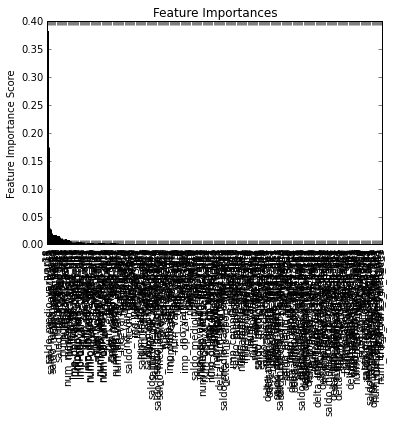

In [18]:
pred = [i for i in train.columns if i not in ['ID', 'TARGET']]
rfc0 = RandomForestClassifier(n_estimators = 500, \
                              random_state = 42)
modelFit(rfc0, train, pred, 'TARGET')

In [20]:
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("\nModel with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(score.mean_validation_score,np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))


param_dist = {"max_depth": sp_randint(3,10),
              "max_features": sp_randint(15, 29),
              "min_samples_split": sp_randint(400, 600),
              "min_samples_leaf": sp_randint(40, 60),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

random_search = RandomizedSearchCV(rfc0, param_distributions = param_dist, n_iter = 20)
random_search.fit(train[pred], train['TARGET'])
report(random_search.grid_scores_)


Model with rank: 1
Mean validation score: 0.960 (std: 0.000)
Parameters: {'bootstrap': True, 'min_samples_leaf': 45, 'min_samples_split': 404, 'criterion': 'gini', 'max_features': 24, 'max_depth': 8}

Model with rank: 2
Mean validation score: 0.960 (std: 0.000)
Parameters: {'bootstrap': False, 'min_samples_leaf': 45, 'min_samples_split': 554, 'criterion': 'gini', 'max_features': 24, 'max_depth': 6}

Model with rank: 3
Mean validation score: 0.960 (std: 0.000)
Parameters: {'bootstrap': True, 'min_samples_leaf': 52, 'min_samples_split': 597, 'criterion': 'entropy', 'max_features': 28, 'max_depth': 4}



Model Report
Accuracy : 0.9604
AUC Score (Train): 0.829936
CV Score: Mean - 0.8143097 | Std - 0.01102252 | Min - 0.8001729 | Max - 0.830038


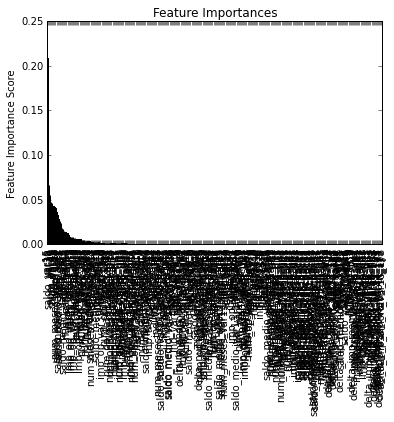

In [21]:
rfc1 = RandomForestClassifier(n_estimators = 500, \
                              max_depth = 8, \
                              max_features = 24, \
                              min_samples_split = 404, \
                              min_samples_leaf = 45, \
                              bootstrap = True, \
                              random_state = 42)
modelFit(rfc1, train, pred, 'TARGET')